<a href="https://colab.research.google.com/github/KilianK1998/Platelet-surface-expression-and-reactivity/blob/main/Differential_activators_python_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install FlowCytometryTools

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from FlowCytometryTools import FCMeasurement
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

In [ ]:
def summorize_fcs(meta, data_path):
    '''
    Function that writes medians of each channel into a file
    :param meta: pandas dataframe with metadata with the following columns: 
        file_name, sample_id, condition, patient_id. See example of the metadata table below
    
    :param data_path: path to .fsc files
    
    ** Windows Users **
 
    Windows uses the backslash character (‘\’) for paths. However, the backslash character
    is a special character in python that is used for formatting strings. 
    In order to specify paths correctly, you must precede the path with the character ‘r’.
 
    Good:
 
    >>> data_path=r'C:\data\'
    Bad:
 
    >>> data_path='C:\data\'
    
    
    :returns: 1) dataframe markers by samples
    2) dictionary with markers as keys and a median values for healthy and patients
    
    '''
    
    files = list(meta.file_name)
    status = list(meta.condition)
    samp = list(meta.sample_id)
    #open the first file to retrieve the order of markers
    sample = FCMeasurement(ID='Sample', datafile=data_path +files[0])
    dat1 = sample.data
    genes = dat1.columns
    genes = [x.split("_")[0] for x in genes]############################################
 
    # matrix with medians for each marker and each sample
    medians_full = np.zeros((len(genes), len(samp)))
    # dictionary with medians for each sample and each condition
    medians_cond = dict()
 
    # file processing is performed per marker to avoid loading too much data into memory
    for i in range(len(genes)):
        gene = genes[i]
        old = 0
        for j in range(len(files)):
            st = status[j]
            file = files[j]
            gr = samp[j]
            sample = FCMeasurement(ID='Sample', datafile=data_path +file)
            dat1 = sample.data
            gs = dat1.columns
            genes_new = [x.split("_")[0] for x in gs]#####################################
            dat1.columns = genes_new
            new_dat = dat1[[gene]]
            new_dat.columns = ["expression"]
            new_dat["group"] = [gr]*dat1.shape[0]
            new_dat["antibody"] = [gene]*dat1.shape[0]
            new_dat["status"] = [st]*dat1.shape[0]
            new_dat.index = np.arange(old,dat1.shape[0]+old)
            old = dat1.shape[0] + old
            if j == 0:
                all_dat = new_dat.copy()
            else:    
                all_dat = pd.concat([all_dat, new_dat])
        #data transformation
        all_dat.expression = np.arcsinh(all_dat.expression/5)
        #medians for healthy and patients
        hp = all_dat['expression'][all_dat['status'] == 'healthy']
        cp = all_dat['expression'][all_dat['status'] == 'patient']
        medians_cond[gene] = [np.median(hp), np.median(cp)]
        #medians for each sample
        for j in range(len(samp)):
            s = samp[j]
            condition = (all_dat['group'] == s) 
            vals = all_dat['expression'][condition]
            medians_full[i,j] = np.median(vals)
    medians_full = pd.DataFrame(medians_full, index = genes, columns = samp)
    return(medians_full, medians_cond)
 
 
def pv_estimate(dat, markers, model):
    '''
    Computes p-values based on LMM and then performs FDR correction
    :param dat: pandas dataframe
    :param markers: a list of markers to test
    :param model: a string with model description
    '''
    pvs = []
    for m in markers:
        d = dat[dat.marker == m]
        md = smf.mixedlm(model,d ,
                     groups=d["samples"])
        try:
            mdf = md.fit()
 
            pvs.append((m,mdf.pvalues[1]))
        except np.linalg.LinAlgError:
            pvs.append((m,np.nan))
    # for correction we save only those p-values that were actually computed and did not crash due to 0 variance
    ms = []
    ps = []
    for g,p in pvs:
        if not np.isnan(p):
            ps.append(p)
            ms.append(g)
    #FDR correction
    _, new_pv = sm.stats.fdrcorrection(ps, alpha=0.05, method='indep', is_sorted=False)
    result = dict()
    for i in range(len(new_pv)):
        result[ms[i]] = new_pv[i]
    return(result)

# 1. Reading and summorizing the data

## 1.1 Not activated samples

**Metadata:**

In [ ]:
meta_na = pd.read_excel("/content/meta_diffactivatorsCRP.xlsx", sheet_name="Sheet1") #needs to be changed for TRAP
display(meta_na)

,file_name,sample_id,condition,patient_id,condition2
0,Em_B_conc_0_CD41_CD61.fcs,EM_B,healthy,EM,baseline
1,Me_B_01_1_CD41_CD61.fcs,ME_B,healthy,ME,baseline
2,Pa_B_01_1_CD41_CD61.fcs,PA_B,healthy,PA,baseline
3,RPs183_B_01_1_CD41_CD61.fcs,SA_B,healthy,SA,baseline
4,1_B_01_1_CD41_CD61.fcs,SP_1_B,healthy,SP_1,baseline
5,2_B_02_1_CD41_CD61.fcs,SP_2_B,healthy,SP_2,baseline
6,3_B_02_1_CD41_CD61.fcs,SP_3_B,healthy,SP_3,baseline
7,4_B_02_1_CD41_CD61.fcs,SP_4_B,healthy,SP_4,baseline
8,5_B_02_1_CD41_CD61.fcs,SP_5_B,healthy,SP_5,baseline
9,6_B_01_1_CD41_CD61.fcs,SP_6_B,healthy,SP_6,baseline


**Reading .fcs and summarising the data into medians**

In [ ]:
# create folder named: files_na
files = "/content/files_na/"

medians_full_na, medians_cond_na = summorize_fcs(meta_na, files)



In [ ]:
medians_full_na.head()

,EM_B,ME_B,PA_B,SA_B,SP_1_B,SP_2_B,SP_3_B,SP_4_B,SP_5_B,SP_6_B
Time,13.133640,12.723577,12.638721,12.206644,12.654980,12.934866,12.724089,12.475872,12.722153,12.622190
Event,1.937879,1.818447,1.937879,1.992836,1.683743,1.683743,1.879864,1.818447,1.683743,1.879864
89Y,1.493143,0.822863,1.830789,1.595505,1.293857,1.528054,2.443030,2.472413,1.705180,2.178416
102Pd,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
103Rh,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 1.2 Activated samples

In [ ]:
meta_act = pd.read_excel("/content/meta_diffactivators_activatedCRP.xlsx", sheet_name="Sheet1") #needs to be changed for TRAP
display(meta_act)

,file_name,sample_id,condition,patient_id,condition2
0,1_C_01_1_CD41_CD61.fcs,SP_1_A,healthy,SP_1,CRP
1,2_C_2_02_1_CD41_CD61.fcs,SP_2_A,healthy,SP_2,CRP
2,3_C_02_1_CD41_CD61.fcs,SP_3_A,healthy,SP_3,CRP
3,4_C_02_1_CD41_CD61.fcs,SP_4_A,healthy,SP_4,CRP
4,5_C_2_1_0_CD41_CD61.fcs,SP_5_A,healthy,SP_5,CRP
5,6_C_02_1_CD41_CD61.fcs,SP_6_A,healthy,SP_6,CRP
6,Em_C_02_1_CD41_CD61.fcs,EM_C,healthy,EM,CRP
7,Me_C_01_1_CD41_CD61.fcs,ME_C,healthy,ME,CRP
8,Pa_C_01_1_CD41_CD61.fcs,PA_C,healthy,PA,CRP
9,RPs183_C_01_1_CD41_CD61.fcs,SA_C,healthy,SA,CRP


In [ ]:
files = "/content/files_activated/"
medians_full_act, medians_cond_act = summorize_fcs(meta_act, files)

In [ ]:
medians_full_act.head()

,SP_1_A,SP_2_A,SP_3_A,SP_4_A,SP_5_A,SP_6_A,EM_C,ME_C,PA_C,SA_C
Time,13.198353,12.422470,12.704009,12.712312,12.623521,13.040325,12.418087,12.551002,12.534201,12.469955
Event,1.818447,1.879864,1.937879,1.937879,1.992836,1.937879,2.187422,1.937879,1.937879,2.187422
89Y,1.885659,1.883211,3.192469,3.224621,3.010191,2.789806,2.242198,0.970418,1.250300,2.116961
102Pd,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
103Rh,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 1.3 Concatinating both datasets together for further analysis

In [ ]:
meta = pd.concat([meta_na,meta_act], ignore_index=True)
markers = medians_full_na.index
samples = medians_full_na.columns
conditions = [list(meta_na.condition[meta_na.sample_id == x])[0] for x in samples]

conditions1 = [list(meta_na.condition2[meta_na.sample_id == x])[0] for x in samples]
conditions2 = list(meta_act.condition2)

last_i = 0
for i in range(len(markers)):
    m = markers[i]
    dat1 = medians_full_na.loc[[m]].T
    dat1.columns = ["expression"]
    dat1["samples"] = dat1.index
    dat1.index= np.arange(last_i,dat1.shape[0]+last_i)
    last_i = dat1.shape[0] +last_i
    dat1["marker"] = [m]*dat1.shape[0]
    dat1["condition"] = conditions
    dat1["type"] = ["not activated"]*dat1.shape[0]
    dat1["condition2"] = conditions1
    if i == 0:
        dat = dat1
    else:
        dat = pd.concat([dat,dat1])

markers = medians_full_act.index
samples = medians_full_act.columns
conditions = [list(meta_act.condition[meta_act.sample_id == x])[0] for x in samples]        
for i in range(len(markers)):
    m = markers[i]
    dat1 = medians_full_act.loc[[m]].T
    dat1.columns = ["expression"]
    dat1["samples"] = dat1.index
    dat1.index= np.arange(last_i,dat1.shape[0]+last_i)
    last_i = dat1.shape[0] +last_i
    dat1["marker"] = [m]*dat1.shape[0]
    dat1["condition"] = conditions
    dat1["type"] = ["activated"]*dat1.shape[0]
    dat1["condition2"] = conditions2


    dat = pd.concat([dat,dat1])

# 3. Activation slope analysis

## 3.1 Linear model approach

In [ ]:
dat["patient"] = [x[:-1] for x in dat["samples"]]
ylims = {"CD63": (0,3), "CD107a": (-0.1,1.1), "PAC1": (3.5, 5.8), "CD62P": (0, 5.6), "CD154": (-0.2,0.6)}

act_m = ["155Gd", "150Nd", "151Eu", "161Dy", "168Er"]
panel = list(set(markers).difference(set(act_m)))


### 3.1.1 TRAP-stimulation

,expression,samples,marker,condition,type,condition2,patient
847,3.789622,DN1_A,155Gd,healthy,activated,TRAP,DN1_
848,2.800193,DN2_A,155Gd,healthy,activated,TRAP,DN2_
849,2.504350,DN6_A,155Gd,healthy,activated,TRAP,DN6_
850,3.233912,DN7_A,155Gd,healthy,activated,TRAP,DN7_
851,1.815123,DN8_A,155Gd,healthy,activated,TRAP,DN8_
852,1.039166,DN10_A,155Gd,healthy,activated,TRAP,DN10_
853,1.328322,DN12_A,155Gd,healthy,activated,TRAP,DN12_
854,1.959624,EM_A,155Gd,healthy,activated,TRAP,EM_
855,0.000000,ME_A,155Gd,healthy,activated,TRAP,ME_
856,0.144446,PA_A,155Gd,healthy,activated,TRAP,PA_


,expression,samples,marker,condition,type,condition2,patient
792,2.069076,DN1_A,150Nd,healthy,activated,TRAP,DN1_
793,1.670780,DN2_A,150Nd,healthy,activated,TRAP,DN2_
794,1.692209,DN6_A,150Nd,healthy,activated,TRAP,DN6_
795,1.512040,DN7_A,150Nd,healthy,activated,TRAP,DN7_
796,2.312015,DN8_A,150Nd,healthy,activated,TRAP,DN8_
797,1.795981,DN10_A,150Nd,healthy,activated,TRAP,DN10_
798,1.378596,DN12_A,150Nd,healthy,activated,TRAP,DN12_
799,2.481067,EM_A,150Nd,healthy,activated,TRAP,EM_
800,1.776535,ME_A,150Nd,healthy,activated,TRAP,ME_
801,2.580929,PA_A,150Nd,healthy,activated,TRAP,PA_


,expression,samples,marker,condition,type,condition2,patient
803,0.134366,DN1_A,151Eu,healthy,activated,TRAP,DN1_
804,0.000000,DN2_A,151Eu,healthy,activated,TRAP,DN2_
805,0.000000,DN6_A,151Eu,healthy,activated,TRAP,DN6_
806,0.000000,DN7_A,151Eu,healthy,activated,TRAP,DN7_
807,0.629267,DN8_A,151Eu,healthy,activated,TRAP,DN8_
808,0.268995,DN10_A,151Eu,healthy,activated,TRAP,DN10_
809,0.096434,DN12_A,151Eu,healthy,activated,TRAP,DN12_
810,0.787163,EM_A,151Eu,healthy,activated,TRAP,EM_
811,0.378094,ME_A,151Eu,healthy,activated,TRAP,ME_
812,0.968905,PA_A,151Eu,healthy,activated,TRAP,PA_


,expression,samples,marker,condition,type,condition2,patient
869,4.616299,DN1_A,161Dy,healthy,activated,TRAP,DN1_
870,4.137082,DN2_A,161Dy,healthy,activated,TRAP,DN2_
871,3.878491,DN6_A,161Dy,healthy,activated,TRAP,DN6_
872,3.812685,DN7_A,161Dy,healthy,activated,TRAP,DN7_
873,4.842882,DN8_A,161Dy,healthy,activated,TRAP,DN8_
874,4.471029,DN10_A,161Dy,healthy,activated,TRAP,DN10_
875,3.829371,DN12_A,161Dy,healthy,activated,TRAP,DN12_
876,5.024824,EM_A,161Dy,healthy,activated,TRAP,EM_
877,4.698796,ME_A,161Dy,healthy,activated,TRAP,ME_
878,4.832281,PA_A,161Dy,healthy,activated,TRAP,PA_


,expression,samples,marker,condition,type,condition2,patient
902,0.092747,DN1_A,168Er,healthy,activated,TRAP,DN1_
903,0.134846,DN2_A,168Er,healthy,activated,TRAP,DN2_
904,0.000000,DN6_A,168Er,healthy,activated,TRAP,DN6_
905,0.061639,DN7_A,168Er,healthy,activated,TRAP,DN7_
906,0.315584,DN8_A,168Er,healthy,activated,TRAP,DN8_
907,0.229917,DN10_A,168Er,healthy,activated,TRAP,DN10_
908,0.000000,DN12_A,168Er,healthy,activated,TRAP,DN12_
909,0.419616,EM_A,168Er,healthy,activated,TRAP,EM_
910,0.268311,ME_A,168Er,healthy,activated,TRAP,ME_
911,0.346159,PA_A,168Er,healthy,activated,TRAP,PA_


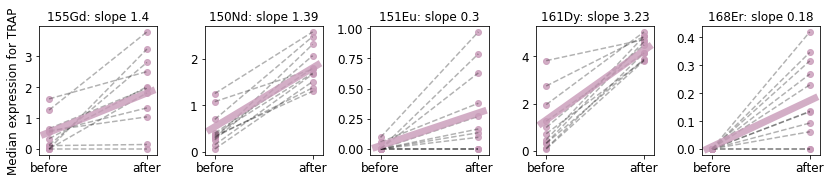

In [ ]:
datT = dat[(dat.condition2 == "TRAP")]
datB = dat[(dat.condition2 == "baseline")]

frames = [datT, datB]

datTB = pd.concat(frames)
#display(datTB)

warnings.filterwarnings("ignore")
fig = plt.figure(figsize=(14, 9))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plt.rc('font', size=12)  # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title
plt.rc('axes', labelsize=12)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)  # fontsize of the tick labels
plt.rc('ytick', labelsize=12)  # fontsize of the tick labels
plt.rc('legend', fontsize=12)

# top panel: only healthy and TRAP
patients = list(set(datTB[datTB.condition == "healthy"]["patient"]))  #
colors = ['#9AB8C8', '#DBA794']
for i in range(len(act_m)):
    ax = fig.add_subplot(3, 5, i+1)
    m= act_m[i]
    d1 = list(datTB[(datTB.marker == m)&(datTB.condition == "healthy")& (datTB.type == "not activated")]["expression"])
    d2 = list(datTB[(datTB.marker == m)&(datTB.condition == "healthy")&(datTB.condition2=="TRAP")& (datTB.type == "activated")]["expression"])
  
  #plot scatter for each marker
    s1 = ax.scatter(np.ones(len(d1)),d1, c = "#c89ab8", alpha = 0.8)
    s2 = ax.scatter(np.ones(len(d1))*2,d2, c = "#c89ab8", alpha = 0.8)
    
  # compute the slope
    d = datTB[(datTB.marker == m) & (datTB.condition == "healthy")]
    display(d)

  # needs to be inserted to avoid zero problem
    if m == '155Gd':
      d.iat[8,0] = 0.0001

    if m == '168Er':
      d.iat[2,0] = 0.00001
      d.iat[6,0] = 0.00001
    #display(d)

    md = smf.mixedlm("expression ~ type",d, groups=d["samples"]) 
    mdf = md.fit()
  
  # print the slope in the plot title
    ax.set_title("{0}: slope {1}".format(m, np.round(np.abs(list(mdf.params)[1]),2)))
  
  # make y lable for the most left plot
    if i == 0:
        ax.set_ylabel('Median expression for TRAP')
  
  # for each pair of patients plot a line from not activated sample to activated
    for p in patients:
         p1 = list(datTB[(datTB.marker == m)&(datTB.condition == "healthy")& (datTB.type == "not activated")&(datTB.patient == p)]["expression"])[0]

         p2 = list(datTB[(datTB.marker == m)&(datTB.condition == "healthy")&(datTB.condition2=="TRAP")&(datTB.type == "activated")&(datTB.patient == p)]["expression"])[0]

         plt.plot([1,2],[p1,p2], c = "black", linestyle = "--", alpha = 0.3)
    
   

    # plot the regression fit
    plt.sca(ax)
    plt.xticks([1,2], [' ', ' '])
    xs = [1,0]
    b0 = mdf.params[0]
    b1 = mdf.params[1]
    ys = [b0 + b1*x for x in xs]
    #ys = [0,0.8]  # use for scale changes
    plt.plot(np.array(ax.get_xlim()),ys, c = '#c89ab8', linestyle = "-", alpha = 0.8, linewidth=7) #9AB8C8 old color
    plt.xticks([1,2], ['before', 'after'])
    try:
      plt.ylim(ylims[m])
    except:
      KeyError
      
plt.savefig("/content/activation_all_together_slope_TRAP.pdf",dpi = 1000)


### 3.1.2 CRP-stimulation

,expression,samples,marker,condition,type,condition2,patient
770,1.000000e-07,SP_1_A,155Gd,healthy,activated,CRP,SP_1_
771,3.004092e+00,SP_2_A,155Gd,healthy,activated,CRP,SP_2_
772,3.828844e+00,SP_3_A,155Gd,healthy,activated,CRP,SP_3_
773,3.560388e+00,SP_4_A,155Gd,healthy,activated,CRP,SP_4_
774,4.058594e+00,SP_5_A,155Gd,healthy,activated,CRP,SP_5_
775,3.651979e+00,SP_6_A,155Gd,healthy,activated,CRP,SP_6_
776,3.608211e+00,EM_C,155Gd,healthy,activated,CRP,EM_
777,3.391347e-02,ME_C,155Gd,healthy,activated,CRP,ME_
778,7.732027e-03,PA_C,155Gd,healthy,activated,CRP,PA_
779,3.970780e+00,SA_C,155Gd,healthy,activated,CRP,SA_


,expression,samples,marker,condition,type,condition2,patient
720,1.000000e-07,SP_1_A,150Nd,healthy,activated,CRP,SP_1_
721,2.119528e+00,SP_2_A,150Nd,healthy,activated,CRP,SP_2_
722,2.403276e+00,SP_3_A,150Nd,healthy,activated,CRP,SP_3_
723,2.127182e+00,SP_4_A,150Nd,healthy,activated,CRP,SP_4_
724,2.298478e+00,SP_5_A,150Nd,healthy,activated,CRP,SP_5_
725,1.825560e+00,SP_6_A,150Nd,healthy,activated,CRP,SP_6_
726,3.666477e+00,EM_C,150Nd,healthy,activated,CRP,EM_
727,2.741362e+00,ME_C,150Nd,healthy,activated,CRP,ME_
728,2.906471e+00,PA_C,150Nd,healthy,activated,CRP,PA_
729,2.859286e+00,SA_C,150Nd,healthy,activated,CRP,SA_


,expression,samples,marker,condition,type,condition2,patient
730,1.000000e-07,SP_1_A,151Eu,healthy,activated,CRP,SP_1_
731,8.453749e-01,SP_2_A,151Eu,healthy,activated,CRP,SP_2_
732,6.431558e-01,SP_3_A,151Eu,healthy,activated,CRP,SP_3_
733,6.509476e-01,SP_4_A,151Eu,healthy,activated,CRP,SP_4_
734,5.784050e-01,SP_5_A,151Eu,healthy,activated,CRP,SP_5_
735,3.273772e-01,SP_6_A,151Eu,healthy,activated,CRP,SP_6_
736,1.812478e+00,EM_C,151Eu,healthy,activated,CRP,EM_
737,1.285561e+00,ME_C,151Eu,healthy,activated,CRP,ME_
738,1.462148e+00,PA_C,151Eu,healthy,activated,CRP,PA_
739,1.175130e+00,SA_C,151Eu,healthy,activated,CRP,SA_


,expression,samples,marker,condition,type,condition2,patient
790,1.000000e-07,SP_1_A,161Dy,healthy,activated,CRP,SP_1_
791,5.215639e+00,SP_2_A,161Dy,healthy,activated,CRP,SP_2_
792,4.921163e+00,SP_3_A,161Dy,healthy,activated,CRP,SP_3_
793,4.959666e+00,SP_4_A,161Dy,healthy,activated,CRP,SP_4_
794,5.119270e+00,SP_5_A,161Dy,healthy,activated,CRP,SP_5_
795,4.655371e+00,SP_6_A,161Dy,healthy,activated,CRP,SP_6_
796,6.048528e+00,EM_C,161Dy,healthy,activated,CRP,EM_
797,4.917014e+00,ME_C,161Dy,healthy,activated,CRP,ME_
798,5.011623e+00,PA_C,161Dy,healthy,activated,CRP,PA_
799,5.708248e+00,SA_C,161Dy,healthy,activated,CRP,SA_


,expression,samples,marker,condition,type,condition2,patient
820,1.000000e-07,SP_1_A,168Er,healthy,activated,CRP,SP_1_
821,4.195954e-01,SP_2_A,168Er,healthy,activated,CRP,SP_2_
822,2.342895e-01,SP_3_A,168Er,healthy,activated,CRP,SP_3_
823,1.914887e-01,SP_4_A,168Er,healthy,activated,CRP,SP_4_
824,2.430014e-01,SP_5_A,168Er,healthy,activated,CRP,SP_5_
825,1.676700e-01,SP_6_A,168Er,healthy,activated,CRP,SP_6_
826,7.778829e-01,EM_C,168Er,healthy,activated,CRP,EM_
827,8.489964e-01,ME_C,168Er,healthy,activated,CRP,ME_
828,6.132057e-01,PA_C,168Er,healthy,activated,CRP,PA_
829,4.818497e-01,SA_C,168Er,healthy,activated,CRP,SA_


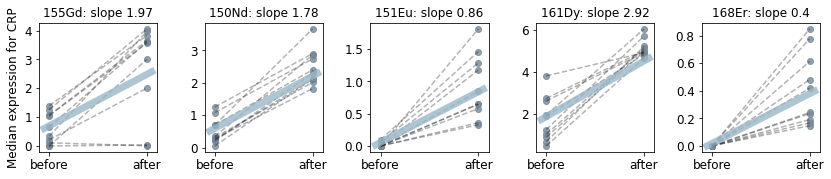

In [ ]:
datC = dat[(dat.condition2 == "CRP")]
datB = dat[(dat.condition2 == "baseline")]
frames = [datC, datB]

datCB = pd.concat(frames)

warnings.filterwarnings("ignore")
fig = plt.figure(figsize=(14, 9))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plt.rc('font', size=12)  # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title
plt.rc('axes', labelsize=12)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)  # fontsize of the tick labels
plt.rc('ytick', labelsize=12)  # fontsize of the tick labels
plt.rc('legend', fontsize=12)

# top panel: only healthy and CRP
patients = list(set(datCB[datCB.condition == "healthy"]["patient"]))  #
colors = ['#9AB8C8', '#DBA794']
for i in range(len(act_m)):
    ax = fig.add_subplot(3, 5, i+1)
    m= act_m[i]
    d1 = list(datCB[(datCB.marker == m)&(datCB.condition == "healthy")&(datCB.type == "not activated")]["expression"])
    d2 = list(datCB[(datCB.marker == m)&(datCB.condition == "healthy")&(datCB.condition2=="CRP")& (datCB.type == "activated")]["expression"])
  
  #plot scatter for each marker
    s1 = ax.scatter(np.ones(len(d1)),d1, c = "#778899", alpha = 0.8)
    s2 = ax.scatter(np.ones(len(d1))*2,d2, c = "#778899", alpha = 0.8)
    
  # compute the slope
    d = datCB[(datCB.marker == m) & (datCB.condition == "healthy")]

  # needs to be inserted to avoid zero problem
    d.iat[0,0] = 0.00001  

    display(d)

    md = smf.mixedlm("expression ~ type",d, groups=d["samples"]) 
    mdf = md.fit()

  # print the slope in the plot title
    ax.set_title("{0}: slope {1}".format(m, np.round(np.abs(list(mdf.params)[1]),2)))
  
  # make y lable for the most left plot
    if i == 0:
        ax.set_ylabel('Median expression for CRP')
  
  # for each pair of patients plot a line from not activated sample to activated
    for p in patients:
         p1 = list(datCB[(datCB.marker == m)&(datCB.condition == "healthy")& (datCB.type == "not activated")&(datCB.patient == p)]["expression"])[0]

         p2 = list(datCB[(datCB.marker == m)&(datCB.condition == "healthy")&(datCB.condition2=="CRP")&(datCB.type == "activated")&(datCB.patient == p)]["expression"])[0]

         plt.plot([1,2],[p1,p2], c = "black", linestyle = "--", alpha = 0.3)
    
   
    # plot the regression fit
    plt.sca(ax)
    plt.xticks([1,2], [' ', ' '])
    xs = [1,0]
    b0 = mdf.params[0]
    b1 = mdf.params[1]
    ys = [b0 + b1*x for x in xs]
    plt.plot(np.array(ax.get_xlim()),ys, c = '#9AB8C8', linestyle = "-", alpha = 0.8, linewidth=7)
    plt.xticks([1,2], ['before', 'after'])
    try:
      plt.ylim(ylims[m])
    except:
      KeyError

plt.savefig("/content/activation_all_together_slope_CRP.pdf",dpi = 1000)